In [481]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

import scipy.stats as stats

In [725]:
mimic = pd.read_csv("mimic_pairs.csv")

mimic = mimic[(mimic.SaO2 >= 70) & (mimic.SpO2 >= 70)]
mimic = mimic[(mimic.SaO2 <= 100) & (mimic.SpO2 <= 100)]
mimic = mimic[mimic.race_group != "Other"]
mimic = mimic[mimic.delta_SpO2 >= -30]

mimic["gap"] = mimic.SpO2 - mimic.SaO2
mimic["race"] = mimic.race_group.apply(lambda x: "White" if x == "White" else "Non-White" )

print(f"MIMIC: {len(mimic)}")

mimic_white = mimic[mimic.race == "White"]
mimic_nonwhite = mimic[mimic.race == "Non-White"]

print(f"White: {mimic_white.gap.mean():.2f} ({mimic_white.gap.std():.2f})")
print(f"Non-White: {mimic_nonwhite.gap.mean():.2f} ({mimic_nonwhite.gap.std():.2f})")

MIMIC: 40400
White: 0.95 (3.05)
Non-White: 1.56 (3.19)


In [726]:
eicu = pd.read_csv("eicu_pairs.csv")

eicu = eicu[(eicu.SaO2 >= 70) & (eicu.SpO2 >= 70)]
eicu = eicu[(eicu.SaO2 <= 100) & (eicu.SpO2 <= 100)]
eicu = eicu[eicu.race_group != "Other"]
eicu = eicu[eicu.delta_SpO2 >= -30]

eicu["gap"] = eicu.SpO2 - eicu.SaO2
eicu["race"] = eicu.race_group.apply(lambda x: "White" if x == "White" else "Non-White" )

print(f"eICU: {len(eicu)}")

eicu_white = eicu[eicu.race == "White"]
eicu_nonwhite = eicu[eicu.race == "Non-White"]

print(f"White: {eicu_white.gap.mean():.2f} ({eicu_white.gap.std():.2f})")
print(f"Non-White: {eicu_nonwhite.gap.mean():.2f} ({eicu_nonwhite.gap.std():.2f})")

eICU: 105214
White: 1.09 (3.85)
Non-White: 1.73 (4.20)


Let's Merge MIMIC and eICU

In [669]:
all_pairs = pd.concat([mimic,eicu],axis=0)[['gap','race']]

Undersampled dataframe 

In [676]:
under_black = all_pairs[all_pairs.race == "White"].sample(len(all_pairs[all_pairs.race == "Non-White"]))
all_pairs_undersampled = pd.concat([all_pairs[all_pairs.race == "Non-White"], under_black], axis=0)

In [682]:
len(all_pairs_undersampled[all_pairs_undersampled.race == "Non-White"])

24918

In [683]:
len(all_pairs_undersampled[all_pairs_undersampled.race == "White"])

24918

Get Model

In [730]:
from sklearn.linear_model import LogisticRegression

data = all_pairs_undersampled

X_train, X_test, y_train, y_test = train_test_split(data.gap, data.race, test_size=0.1, random_state=42)    

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.545
Balanced Accuracy: 0.544
              precision    recall  f1-score   support

   Non-White      0.545     0.487     0.515      2466
       White      0.545     0.601     0.572      2518

    accuracy                          0.545      4984
   macro avg      0.545     0.544     0.543      4984
weighted avg      0.545     0.545     0.543      4984



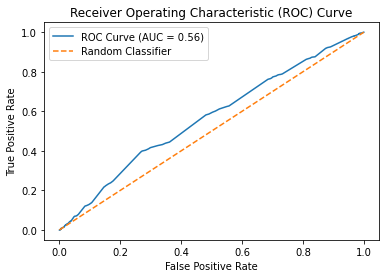

In [700]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs = model.predict_proba(X_test)[:, 1]
y_test = list(y_test.apply(lambda x: 1 if x == "White" else 0))

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_probs)


# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [715]:
# Get the coefficients (weights) of the model
coef = model.coef_[0]

# Get the intercept of the model
intercept = model.intercept_

# Print the coefficients and intercept
print("Coefficients:", coef)
print("Intercept:", intercept)

Coefficients: [-0.04243341]
Intercept: [0.05649425]


In [724]:
def predict_race(gap):
    
    coef = -0.04243341
    intercept = 0.05649425

    z = intercept + coef * gap
    return np.round(1 / (1 + np.exp(-z)))

In [723]:
predict_race()

array([1.])